In [387]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns

In [388]:
RESULTS_FOLDER = "../results"
DATA_FOLDER = "../data"
TEMP_FOLDER = "../tmp"

## Load the training dataset

Load the train dataset in a pandas dataframe

In [389]:
df_train_path = os.path.join(DATA_FOLDER, 'train_dataset.csv')
df_train = pd.read_csv(df_train_path)

## Create additional features

We create the following additional features:

- `history_of_violence` - sum of all violence-related crimes in the past
- `socioeconomic_stability` - 1 / (1 + `priors_count`). If no priors count this will be equal to 1, otherwise it will start getting smaller with each increase of priors


In [390]:
df_train["history_of_violence"] = (
    df_train["juv_fel_count"] +
    df_train["juv_misd_count"] +
    df_train["juv_other_count"] +
    df_train["priors_count"]
)

# Socioeconomic stability proxy
df_train["socioeconomic_stability"] = (1 / (1 + df_train["priors_count"])) 

## Prepare data for model training

- Select features to be used for training
    - `age`
    - `priors_count`
    - `history_of_violence`
    - `days_b_screening_arrest`
    - `socioeconomic_stability`
    - `c_charge_degree_F`
    - `c_charge_degree_M`
- Scale all features, mean 0 and std dev 1


- Select the label for training
    - `two_year_recid` * 10 to put the scale between 0 and 10



In [391]:

X_train = df_train[[ 
    "age", "priors_count", "history_of_violence", 
    "socioeconomic_stability", "c_charge_degree_F", "c_charge_degree_M"
]]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


# y_train = df_train["decile_score"]

y_train = (
    1 * df_train["priors_count"] +
    2 * df_train["history_of_violence"]
)
y_train_normalized =  10 * (y_train - y_train.min()) / (y_train.max() - y_train.min())
# y_train = df_train["two_year_recid"] * 10


## Train linear regression

- limit range of predicted values between 0 and 10

In [392]:

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_train_scaled)
y_pred_normalized =  10 * (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())
# y_pred_normalized = 10 / (1 + np.exp(-y_pred))
# y_pred =  np.clip( np.ceil(y_pred), 0, 10)

## Print the coefficients for linear regression

print intercept and all other coefficients

In [393]:

print("Intercept (w_0):", model.intercept_)

coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_
})

print(coefficients)


Intercept (w_0): 10.88927395598683
                   Feature   Coefficient
0                      age  3.557134e-15
1             priors_count  4.855270e+00
2      history_of_violence  1.038250e+01
3  socioeconomic_stability -3.330132e-15
4        c_charge_degree_F -1.614725e-15
5        c_charge_degree_M  3.391082e-15


In [394]:
import matplotlib.pyplot as plt


def compare_with_two_year_recid(pred_type, y_pred):

    # Categorize predictions into risk groups
    def categorize_score(score):
        if score <= 4:
            return "Low"
        elif 5 <= score <= 7:
            return "Medium"
        else:
            return "High"

    # Add predicted risk group to DataFrame
    df_train[f"Predicted_{pred_type}_Risk_Group"] = pd.Categorical(
        pd.Series(y_pred).map(categorize_score), categories=["Low", "Medium", "High"], ordered=True
    )

    # Group by Predicted Risk Group and Two-Year Recidivism
    predicted_grouped = df_train.groupby([f"Predicted_{pred_type}_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)

    # Save results to CSV
    predicted_grouped.to_csv(f"predicted_vs_recid_{pred_type}.csv")

    # Print summary table
    print("Predicted Risk Group vs Two-Year Recidivism Summary:")
    print(predicted_grouped)

    # Visualization: Predicted Risk Groups vs Two-Year Recidivism
    predicted_grouped.plot(
        kind="bar",
        stacked=True,
        colormap="Oranges",
        figsize=(10, 6),
        title="Predicted Risk Groups vs Two-Year Recidivism"
    )
    plt.xlabel("Predicted Risk Group")
    plt.ylabel("Number of Individuals")
    plt.legend(title="Two-Year Recidivism", loc="upper right")
    plt.tight_layout()
    plt.show()

    # Combine Predictions with Race for Analysis
    race_comparison = df_train.groupby(["race", f"Predicted_{pred_type}_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)

    # Save race-based analysis to CSV
    race_comparison.to_csv(f"predicted_risk_by_race_{pred_type}_summary.csv")
    print("\nRace-Based Comparison of Predicted Risk Groups vs Two-Year Recidivism:")
    print(race_comparison)

    # Visualization: Race-Based Comparison
    races = df_train["race"].unique()
    fig, axes = plt.subplots(len(races), 1, figsize=(10, 6 * len(races)), sharex=True)
    plt.suptitle("Predicted Risk Groups vs Two-Year Recidivism by Race", fontsize=16)

    for i, race in enumerate(races):
        race_data = df_train[df_train["race"] == race]
        grouped_race = race_data.groupby([f"Predicted_{pred_type}_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)
        
        grouped_race.plot(
            kind="bar",
            stacked=True,
            ax=axes[i],
            colormap="viridis",
            title=f"Race: {race}",
        )
        axes[i].set_ylabel("Number of Individuals")
        axes[i].legend(title="Two-Year Recidivism", loc="upper right")

    plt.xlabel("Predicted Risk Group")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


Predicted Risk Group vs Two-Year Recidivism Summary:
two_year_recid                            0     1
Predicted_LinearRegression_Risk_Group            
Low                                    3135  2428
Medium                                   16    69
High                                     24    99


/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_40876/971654235.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  predicted_grouped = df_train.groupby([f"Predicted_{pred_type}_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)


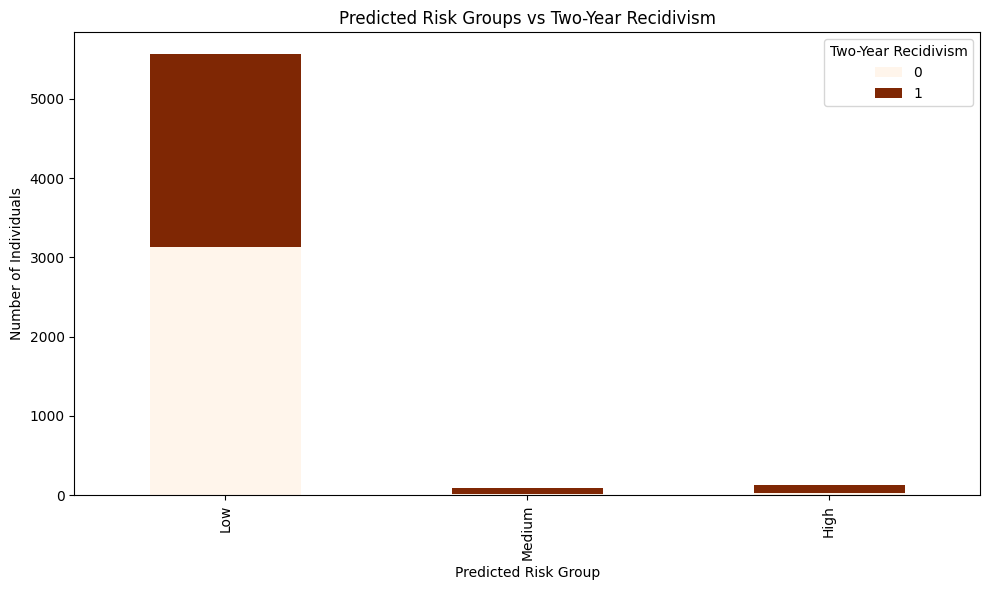


Race-Based Comparison of Predicted Risk Groups vs Two-Year Recidivism:
two_year_recid                                             0     1
race             Predicted_LinearRegression_Risk_Group            
African-American Low                                    1407  1387
                 Medium                                   13    57
                 High                                     20    73
Asian            Low                                      18     8
                 Medium                                    0     0
                 High                                      0     0
Caucasian        Low                                    1194   734
                 Medium                                    2     9
                 High                                      4    20
Hispanic         Low                                     317   186
                 Medium                                    1     2
                 High                                    

/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_40876/971654235.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  race_comparison = df_train.groupby(["race", f"Predicted_{pred_type}_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)
/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_40876/971654235.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_race = race_data.groupby([f"Predicted_{pred_type}_Risk_Group", "two_year_recid"]).size().unstack(fill_value=0)
/var/folders/2h/y479tsnx7xsdv7jvrs2zpk540000gn/T/ipykernel_40876/971654235.py:59: FutureWarning: The default of 

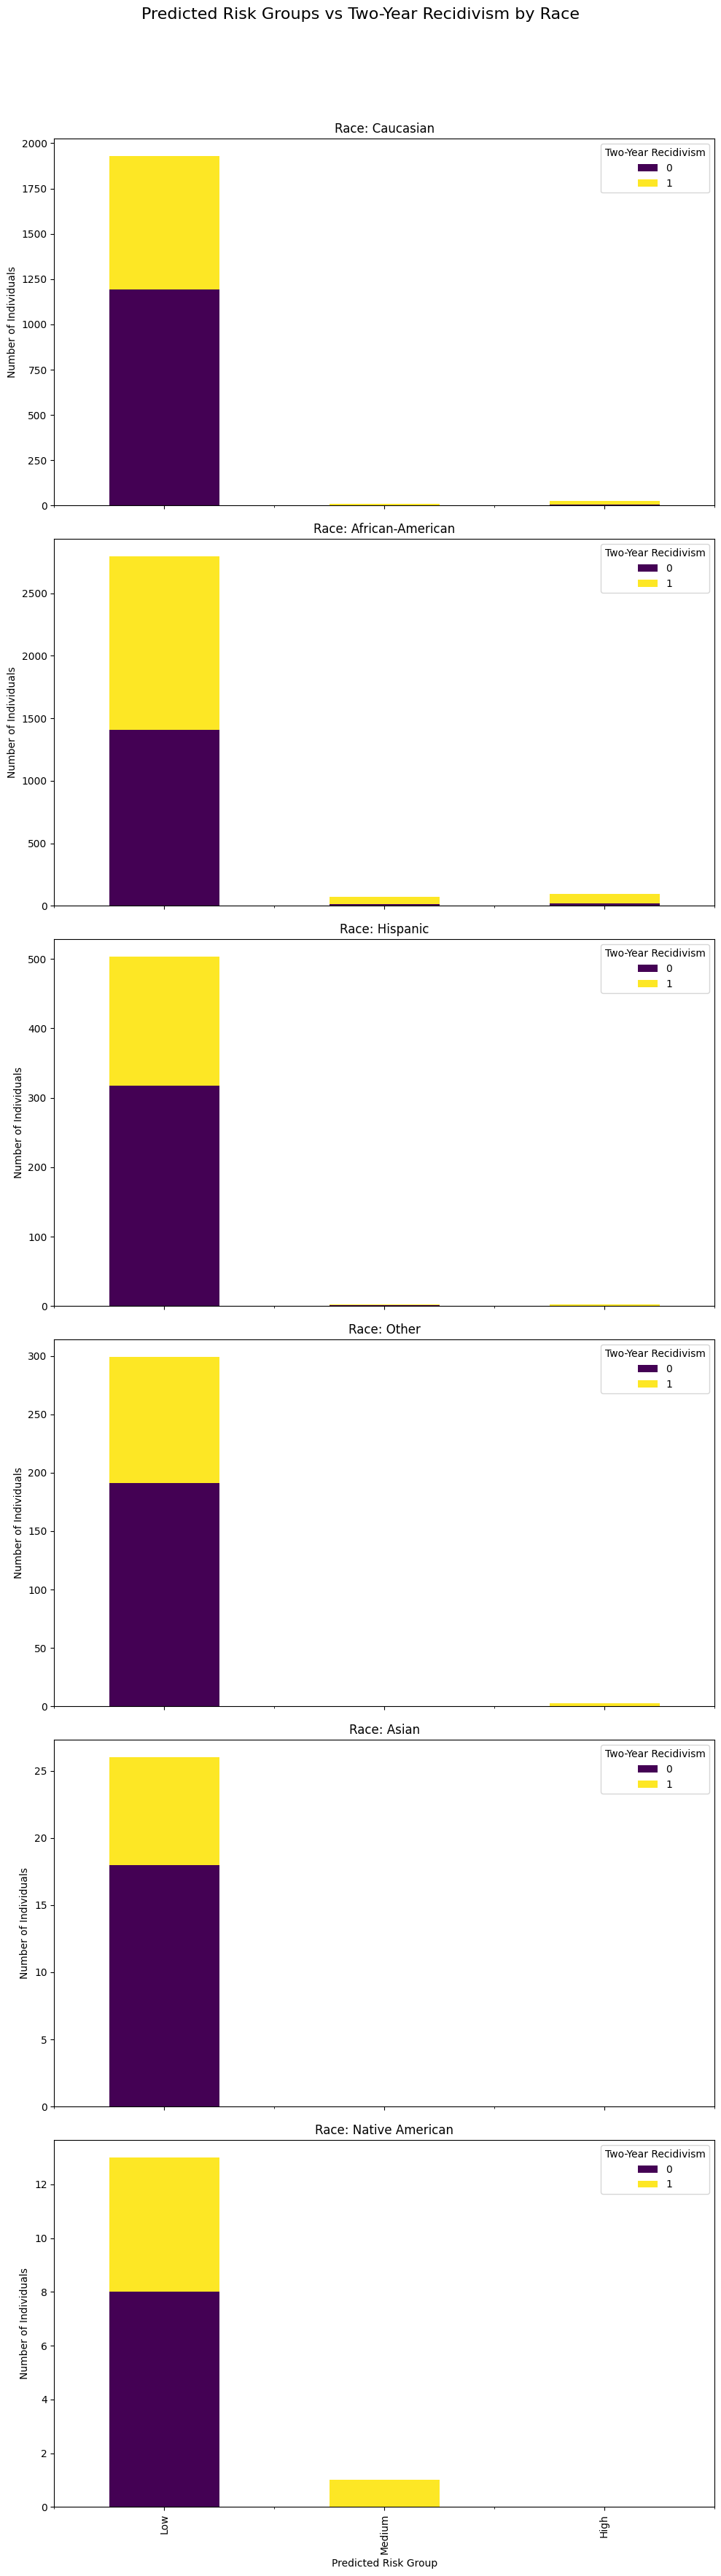

In [395]:
compare_with_two_year_recid("LinearRegression", y_pred_normalized)

In [396]:
print(max(y_pred_normalized))
print(min(y_pred_normalized))

10.0
0.0
